In [1]:

import re
import seaborn as sbn
import nltk
import tqdm as tqdm
import sqlite3
import pandas as pd
import numpy as np

import string
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words("english")
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from math import floor,ceil
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.svm import LinearSVC

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding


from gensim import summarization
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split




[nltk_data] Error loading stopwords: <urlopen error [WinError 10061]
[nltk_data]     由于目标计算机积极拒绝，无法连接。>
c:\Users\15726\anaconda3\envs\ds-1\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
review_data_or = pd.read_json('Clothing_Shoes_and_Jewelry_5.json',lines=True)

In [3]:
review_data_or.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [4]:
review_data_or.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278677 entries, 0 to 278676
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      278677 non-null  object
 1   asin            278677 non-null  object
 2   reviewerName    278225 non-null  object
 3   helpful         278677 non-null  object
 4   reviewText      278677 non-null  object
 5   overall         278677 non-null  int64 
 6   summary         278677 non-null  object
 7   unixReviewTime  278677 non-null  int64 
 8   reviewTime      278677 non-null  object
dtypes: int64(2), object(7)
memory usage: 19.1+ MB


In [5]:
review_data=review_data_or.drop(['reviewerID','asin','reviewerName','summary'],axis=1)


In [6]:
from datetime import datetime
current_date = datetime.now()
# Define a function to calculate the time difference in days
def calculate_time_difference(review_time):
    return (current_date - datetime.strptime(review_time, "%m %d, %Y")).days

# Apply the function to the 'reviewTime' column and replace it
review_data['Review_Interval_Days'] = review_data['reviewTime'].apply(calculate_time_difference)
review_data = review_data.drop(['reviewTime'],axis=1)


In [7]:
review_data['reviewText'] = review_data['reviewText'].astype('string')


In [8]:
review_data.head()

,helpful,reviewText,overall,unixReviewTime,Review_Interval_Days
0,"[0, 0]",This is a great tutu and at a really great pri...,5,1297468800,4634
1,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,1358553600,3927
2,"[0, 0]",What can I say... my daughters have it in oran...,5,1357257600,3942
3,"[0, 0]","We bought several tutus at once, and they are ...",5,1398556800,3464
4,"[0, 0]",Thank you Halo Heaven great product for Little...,5,1394841600,3507


In [9]:
reviews = review_data

reviews[['helpful','total']] = pd.DataFrame(reviews.helpful.values.tolist(), index=reviews.index)
############删掉没有评价是否有用的评论############################
reviews = reviews[reviews['total'] > 0]
#reviews["sentiment"] = reviews["overall"].apply(lambda score: 1 if score > 3 else 1)
reviews["usefulScore"] = (reviews["helpful"]/reviews["total"]).apply(lambda n: n if n > 0 else 0)
#.apply(lambda n: "useful" if n > 0.8 else "useless")

review_data = reviews.drop(['helpful','total'],axis=1)
review_data.head(10)


C:\Users\15726\AppData\Local\Temp\ipykernel_9692\3796216857.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews["usefulScore"] = (reviews["helpful"]/reviews["total"]).apply(lambda n: n if n > 0 else 0)


,reviewText,overall,unixReviewTime,Review_Interval_Days,usefulScore
9,For what I paid for two tutus is unbeatable an...,5,1349568000,4031,0.875000
13,Full and well stitched. This tutu is a beauti...,5,1361664000,3891,1.000000
22,"Prompt delivery, and it is exactly as describe...",4,1365552000,3846,0.500000
23,The minute I saw this my heart skipped a beat....,5,1383782400,3635,1.000000
24,Love this Jewelry Box so well put together ho...,5,1390089600,3562,0.000000
25,This products is great for anyone with a lot o...,5,1348444800,4044,0.500000
30,"The product itself is five stars, however the ...",4,1322956800,4339,0.980488
31,The first question was which computers to inst...,4,1285027200,4778,0.833333
32,"Okay, I admit it. I'm one of the millions of A...",5,1308182400,4510,0.846154
33,I bought this product a little over a year ago...,1,1348185600,4047,0.774194


In [10]:
a = review_data['overall'].value_counts()
print(a)

5    46636
4    17300
3    10670
2     6420
1     5995
Name: overall, dtype: int64


# Data Cleaning

In [11]:
count = 0
for i in review_data['reviewText']:
    if i == '':
        
        count = count+1
count

18

In [12]:
review_data = review_data[review_data['reviewText'] != '']

In [13]:
import nltk
#nlp = spacy.load("en_core_web_sm")
# 下载NLTK的punkt句子分割模型（只需要执行一次）
nltk.download('punkt')

from nltk.tokenize import sent_tokenize

def split_sentences(text):

  try:
   punctuation = ['.', '!', '?']
    
        # 去除句子末尾的空格
   text = text.rstrip()
    
     # 检查句末是否有标点符号
   if text[-1] not in punctuation:
        # 如果没有标点符号，就添加一个句号
      text = f'{text}.'
   sentences = sent_tokenize(text)

   return sentences
  except Exception as e:
    print(f"Error: {e}, Text: {text}")


review_data['reviewText']= review_data['reviewText'].apply(split_sentences)
#sample =split_sentences( review_data['reviewText'][9827])
#sample


[nltk_data] Error loading punkt: <urlopen error [WinError 10061]
[nltk_data]     由于目标计算机积极拒绝，无法连接。>


In [14]:

def data_clean( rev, remove_stopwords=True): 
    cre = []
    sen = []
    for i in rev:
        
        #去除特殊字符
        new_text = re.sub("[^a-zA-Z]"," ", i)
        #小写
        words = new_text.lower().split()
        # 去除停用词 the、a、an、and、in、on 
        if remove_stopwords:
            sts = set(stopwords.words("english"))
            words = [w for w in words if not w in sts]
        sen.append(' '.join(words))
    cre.append('. '.join(sen))
    cre = cre[0]
   
    punctuation = ['.', '!', '?']

    # 去除句子末尾的空格
    cre = cre.rstrip()

    # 检查句末是否有标点符号
    try:
        if cre[-1] not in punctuation:
    # 如果没有标点符号，就添加一个句号
         cre = f'{cre}.'
         return(cre)
    except Exception as e:
        return(cre)
    #ary=[]
    #  the word "jumping" might be stemmed to "jump," and "running" might be stemmed to "run."
    #eng_stemmer = english_stemmer 
    #for word in words:
    #    ary.append(eng_stemmer.stem(word))
            
    

In [15]:
review_data['Clean_review'] = review_data['reviewText'].apply(data_clean)

In [16]:
review_data = review_data[review_data['Clean_review'] != '']

In [17]:
n=0
for review in review_data.reviewText: 
    if n <= 10:
        print(review)
        n = n+1

['For what I paid for two tutus is unbeatable anywhere!', 'I ordered a pink and turquios and they are vibrant and beautiful!', 'The tutu is very full!', 'Princess style!', 'Not cheaply made!', 'Not cheap materia!', 'Obviously someone made these with love and care!', 'I paid less than 7 bucks for a tutu I and I feel proud of my self for researching to the point of finding gold!Recommend 2-6 years!My daughter is two !', 'Wears size 4t and this skirt ( one size ) fit perfect and will probaly be able to accommodate her quickly growing waist for some time!']
['Full and well stitched.', 'This tutu is a beautiful purple color that looks just like the picture.', 'It looks just adorable on our little fairy.']
['Prompt delivery, and it is exactly as described.', "The only reason I did not give it 5 stars is because I haven't washed it yet- so I don't know how it will hold up... Other than that my little girl LOVES her tutus (we got one in light pink also), especially spinning and running in them

In [18]:
review_data = review_data[review_data['Clean_review'].notna() & (review_data['Clean_review'] != '')]

In [19]:
review_data.head()

,reviewText,overall,unixReviewTime,Review_Interval_Days,usefulScore,Clean_review
9,[For what I paid for two tutus is unbeatable a...,5,1349568000,4031,0.875,paid two tutus unbeatable anywhere. ordered pi...
13,"[Full and well stitched., This tutu is a beaut...",5,1361664000,3891,1.000,full well stitched. tutu beautiful purple colo...
22,"[Prompt delivery, and it is exactly as describ...",4,1365552000,3846,0.500,prompt delivery exactly described. reason give...
23,[The minute I saw this my heart skipped a beat...,5,1383782400,3635,1.000,minute saw heart skipped beat. nice case sort ...
24,[Love this Jewelry Box so well put together h...,5,1390089600,3562,0.000,love jewelry box well put together holds plend...


# SMOG指数可读性分析
SMOG指数是一种用于评估文本可读性的指标，它考虑了一个文本中的多音节词的数量。SMOG代表了“Simple Measure of Gobbledygook”（即“混乱简单度量”），是由罗伯特·克拉斯特（Robert Gunning）于1952年提出的。它旨在提供一个简单但有效的方法来估计一段文本的阅读难易程度。

In [20]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83389 entries, 9 to 278676
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewText            83389 non-null  object 
 1   overall               83389 non-null  int64  
 2   unixReviewTime        83389 non-null  int64  
 3   Review_Interval_Days  83389 non-null  int64  
 4   usefulScore           83389 non-null  float64
 5   Clean_review          83389 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 4.5+ MB


In [21]:
sample_data = review_data.sample(n=10000, random_state=42)

In [22]:
sample_data

,reviewText,overall,unixReviewTime,Review_Interval_Days,usefulScore,Clean_review
85791,"[I love these sandals!!, With just a hint of a...",5,1312243200,4463,1.000000,love sandals. hint padded sole much comfortabl...
38690,[I really like these earrings and was delighte...,4,1243555200,5258,1.000000,really like earrings delighted opened box see....
59106,"[Wonderfully comfy., This model goes a bit hig...",5,1302825600,4572,1.000000,wonderfully comfy. model goes bit higher reall...
121686,[The pictures make this beard look really thic...,4,1355961600,3957,0.000000,pictures make beard look really thick warm got...
169970,[I've had the ring less than a week and alread...,5,1356220800,3954,1.000000,ring less week already many compliments. arriv...
...,...,...,...,...,...,...
132094,[This is very comfortable and the fabric is so...,5,1390262400,3560,1.000000,comfortable fabric soft. washes well shrink. l...
201617,"[These boots are sturdier than I expected, con...",5,1362528000,3881,1.000000,boots sturdier expected constructed beautifull...
266448,"[No support., Flimsy., Would classify as a one...",2,1390867200,3553,0.333333,support. flimsy. would classify one time wear ...
203169,[I ordered several allegra K items as a test t...,4,1390694400,3555,0.900000,ordered several allegra k items test see would...


In [23]:
sample_data.reviewText

85791     [I love these sandals!!, With just a hint of a...
38690     [I really like these earrings and was delighte...
59106     [Wonderfully comfy., This model goes a bit hig...
121686    [The pictures make this beard look really thic...
169970    [I've had the ring less than a week and alread...
                                ...                        
132094    [This is very comfortable and the fabric is so...
201617    [These boots are sturdier than I expected, con...
266448    [No support., Flimsy., Would classify as a one...
203169    [I ordered several allegra K items as a test t...
272381    [The material is well draped and is very flatt...
Name: reviewText, Length: 10000, dtype: object

In [24]:
from textatistic import Textatistic

# 定义一个函数来计算SMOG指数
def calculate_smog(text):
    try:
        stats = Textatistic(text)
        return stats.smog_score
    except Exception as e:
        print(f"Error calculating SMOG for text: {e}/n{text}")
        return 0

# 示例用法
readability_scores = []

for i in sample_data.Clean_review:
    smog = calculate_smog(i)
    readability_scores.append(smog)

sample_data['Readability'] = readability_scores


Error calculating SMOG for text: division by zero/ndecent dress feel like worry ruining partying etc etc etc.


## Test of SentimentIntensity Analysis极性分析


In [25]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
#sample_review = review_data.reviewText[:10]
Review_Polarity = []
for test in sample_data.Clean_review:
    ss = analyser.polarity_scores(test) #极性分析
    #for k in sorted(ss):
        #print('{0}: {1}, '.format(k, ss[k]))
    Review_Polarity.append(ss['compound'])
    #print(test)
Review_Polarity[:10]
sample_data['Polarity'] = Review_Polarity

# 主观性分析 TextBlob


In [26]:
from textblob import TextBlob, Word, Blobber
sample_data['Subjectivity'] = sample_data['Clean_review'].apply(lambda x: TextBlob(x).sentiment[1])



In [27]:
sample_data = sample_data.drop(['reviewText','Clean_review'],axis=1)

In [28]:
sample_data

,overall,unixReviewTime,Review_Interval_Days,usefulScore,Readability,Polarity,Subjectivity
85791,5,1312243200,4463,1.000000,7.554174,0.9618,0.564815
38690,4,1243555200,5258,1.000000,8.841846,0.9092,0.600000
59106,5,1302825600,4572,1.000000,5.683918,0.9432,0.538571
121686,4,1355961600,3957,0.000000,3.129100,0.6573,0.731250
169970,5,1356220800,3954,1.000000,7.793538,0.8360,0.522222
...,...,...,...,...,...,...,...
132094,5,1390262400,3560,1.000000,6.427356,0.8437,0.455495
201617,5,1362528000,3881,1.000000,8.841846,0.9477,0.612500
266448,2,1390867200,3553,0.333333,3.129100,-0.0767,1.000000
203169,4,1390694400,3555,0.900000,9.558584,0.9453,0.451774


# distribution of usefulScore is heavily skewed towards 0

In [29]:
sample_data.describe()

,overall,unixReviewTime,Review_Interval_Days,usefulScore,Readability,Polarity,Subjectivity
count,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.039800,1.361502e+09,3892.877600,0.782461,6.882457,0.722176,0.557511
std,1.259275,3.715402e+07,430.023339,0.345669,2.361476,0.372035,0.147806
min,1.000000,1.127261e+09,3380.000000,0.000000,0.000000,-0.966100,0.000000
25%,3.000000,1.351534e+09,3602.000000,0.666667,5.985473,0.670500,0.467919
50%,5.000000,1.370131e+09,3793.000000,1.000000,7.168622,0.877900,0.554167
75%,5.000000,1.386634e+09,4008.250000,1.000000,8.238736,0.947700,0.645000
max,5.000000,1.405814e+09,6604.000000,1.000000,22.918634,0.999800,1.000000


In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
b = sample_data.usefulScore.value_counts().sort_index()
b



0.000000    1277
0.027451       1
0.040268       1
0.083333       1
0.090909       1
            ... 
0.985915       1
0.986842       1
0.988235       1
0.991870       1
1.000000    6049
Name: usefulScore, Length: 182, dtype: int64

In [31]:
bins = pd.cut(sample_data['usefulScore'], bins=10)

# 计算每个区间的计数
counts = bins.value_counts().sort_index()
counts

(-0.001, 0.1]    1281
(0.1, 0.2]         32
(0.2, 0.3]         29
(0.3, 0.4]         93
(0.4, 0.5]        840
(0.5, 0.6]         81
(0.6, 0.7]        422
(0.7, 0.8]        501
(0.8, 0.9]        385
(0.9, 1.0]       6336
Name: usefulScore, dtype: int64

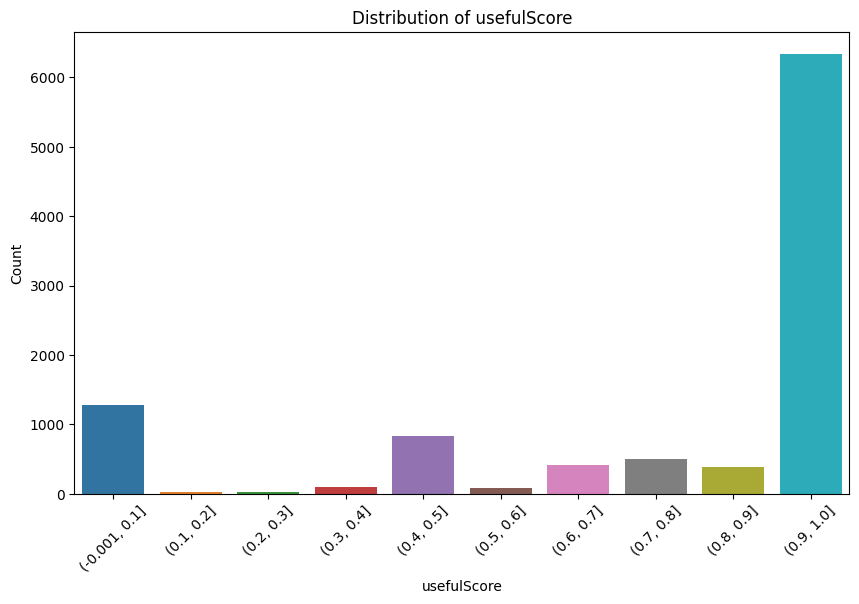

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 sample_data 包含了你的数据
# 例如：sample_data = pd.read_csv('your_data.csv')

# 将 usefulScore 列的值分成十个区间
bins = pd.cut(sample_data['usefulScore'], bins=10)

# 计算每个区间的计数
counts = bins.value_counts().sort_index()

# 绘制 barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values)
plt.xlabel('usefulScore')
plt.ylabel('Count')
plt.title('Distribution of usefulScore')
plt.xticks(rotation=45)
plt.show()


# 样本不均衡，AUC=0.5


In [33]:
b

0.000000    1277
0.027451       1
0.040268       1
0.083333       1
0.090909       1
            ... 
0.985915       1
0.986842       1
0.988235       1
0.991870       1
1.000000    6049
Name: usefulScore, Length: 182, dtype: int64

# 归一化

In [34]:
from sklearn.preprocessing import MinMaxScaler

# 选择需要归一化的特征
features_to_normalize = ['overall', 'unixReviewTime', 'Review_Interval_Days', 'Readability', 'Polarity']

# 初始化MinMaxScaler
scaler = MinMaxScaler()

# 对特征进行归一化
sample_data[features_to_normalize] = scaler.fit_transform(sample_data[features_to_normalize])

# 输出归一化后的数据
print(sample_data)


        overall  unixReviewTime  Review_Interval_Days  usefulScore  \
85791      1.00        0.664082              0.335918     1.000000   
38690      0.75        0.417494              0.582506     1.000000   
59106      1.00        0.630273              0.369727     1.000000   
121686     0.75        0.821030              0.178970     0.000000   
169970     1.00        0.821960              0.178040     1.000000   
...         ...             ...                   ...          ...   
132094     1.00        0.944169              0.055831     1.000000   
201617     1.00        0.844603              0.155397     1.000000   
266448     0.25        0.946340              0.053660     0.333333   
203169     0.75        0.945720              0.054280     0.900000   
272381     1.00        0.930521              0.069479     1.000000   

        Readability  Polarity  Subjectivity  
85791      0.329608  0.980670      0.564815  
38690      0.385793  0.953914      0.600000  
59106      0.248004  

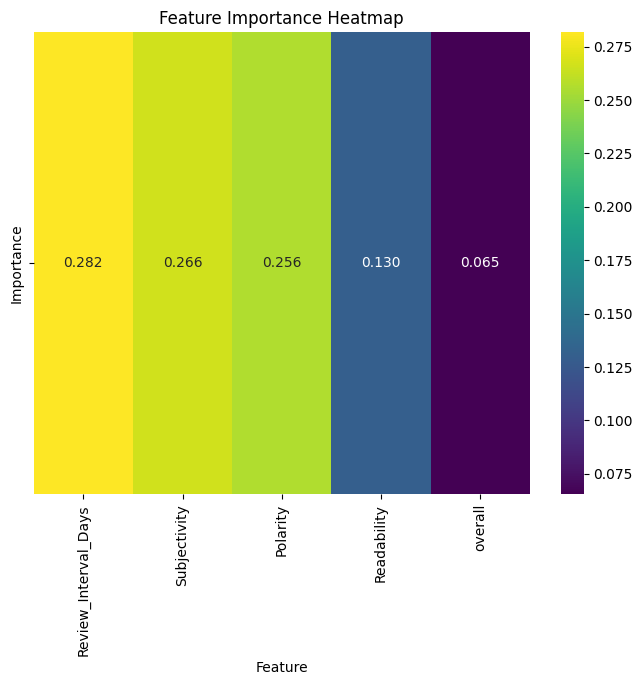

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Assuming 'data' contains the features and labels (overall, Review_Interval_Days, Readability, Polarity)
# X contains the features, y contains the labels
X = sample_data[['overall', 'Review_Interval_Days', 'Readability', 'Polarity','Subjectivity']].values
y = sample_data['usefulScore'].values




# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X, y)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame with feature names and their importances
importance_df = pd.DataFrame({'Feature': ['overall', 'Review_Interval_Days', 'Readability', 'Polarity','Subjectivity'],
                              'Importance': feature_importances})


# Create the heatmap
plt.figure(figsize=(8, 6))
heatmap_data = importance_df.set_index('Feature')['Importance'].sort_values(ascending=False).to_frame().T
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='.3f')
plt.title('Feature Importance Heatmap')
plt.show()

In [36]:
# 不用交叉验证，没必要，时间长，结果差不多
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report



# Assuming 'data' contains the features and labels (overall, Review_Interval_Days, Readability, Polarity)
# X contains the features, y contains the labels
X = sample_data[['overall', 'Review_Interval_Days', 'Readability', 'Polarity','Subjectivity']].values
y = sample_data['usefulScore'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)





In [37]:

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)



In [38]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
threshold = 0.6

In [39]:
#################处理样本不平衡

from sklearn.utils import resample

# 将数据分成特征 (X) 和目标 (y)
# 替换成你的特征数据
y = sample_data['usefulScore']  # 替换成你的目标数据


# 将数据分成正例和负例
positive_samples = sample_data[y > threshold]
negative_samples = sample_data[y <= threshold]

# 从负例中随机采样生成合成样本
synthetic_samples = resample(negative_samples, n_samples=len(positive_samples), random_state=42)

# 将正例和合成样本合并
balanced_data = pd.concat([positive_samples, synthetic_samples])

# balanced_data 包含了处理后的平衡数据，你可以将其用于训练模型
X = balanced_data[['overall', 'Review_Interval_Days', 'Readability', 'Polarity','Subjectivity']].values
y = balanced_data['usefulScore'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_binary = (y_train > threshold).astype(int)
y_test_binary = (y_test > threshold).astype(int)


In [40]:
######阈值？？？？？？？？？？？？？？useful>0.7 auc = 0.89
# 神经网络

# Train the model
model1 = Sequential()
model1.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

# Compile the model with binary cross entropy loss
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model1.fit(X_train, y_train_binary, epochs=10, batch_size=32, verbose=1)


# Evaluate the model
y_pred = model1.predict(X_test)
accuracy = model1.evaluate(X_test, y_test_binary)[1]
print(f'Accuracy: {accuracy}')
##0.859499 ---> 0.8644 dataclean


Epoch 1/10


In [ ]:
from sklearn.metrics import roc_auc_score
# 使用 roc_auc_score 函数计算AUC
y_pred_binary = (model1.predict(X_test) > threshold).astype(int)
auc_score = roc_auc_score(y_test_binary, y_pred_binary)

print(f"AUC Score: {auc_score}")

96/96 [==============================] - 0s 2ms/step
AUC Score: 0.551970383072521


# 阈值判断

In [ ]:
import matplotlib.pyplot as plt


# 生成一系列的阈值
thresholds = [i/20 for i in range(21)]

# 初始化存储指标的列表
accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []
y_pred =  model1.predict(X_test)
fpr_list = []#假阳性
fnr_list = []#假阴性
# 循环计算每个阈值的指标
for threshold in thresholds:
    
    y_train_binary = (y_train > threshold).astype(int)
    y_test_binary = (y_test > threshold).astype(int)
    model1.fit(X_train, y_train_binary, epochs=10, batch_size=32, verbose=1)
    y_pred = model1.predict(X_test)

    #rf_model.fit(X_train, y_train_binary)
    #y_pred = rf_model.predict(X_test)
    
    
    
    
    y_pred_thresholded = (y_pred > threshold).astype(int)
    
    tp = ((y_test_binary == 1) & (y_pred_thresholded == 1)).sum()
    fp = ((y_test_binary == 0) & (y_pred_thresholded == 1)).sum()
    fn = ((y_test_binary == 1) & (y_pred_thresholded == 0)).sum()
    tn = ((y_test_binary == 0) & (y_pred_thresholded == 0)).sum()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    fpr = fp/(fp+tn)
    fnr = fn/(fn+tp)

    # 将指标添加到列表中
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1_score)
    fpr_list.append(fpr)#假阳性率
    fnr_list.append(fnr)#假阴性率


96/96 [==============================] - 0s 4ms/step
Epoch 1/10
383/383 [==============================] - 1s 3ms/step - loss: 0.5633 - accuracy: 0.7321
Epoch 2/10
383/383 [==============================] - 1s 3ms/step - loss: 0.5539 - accuracy: 0.7394
Epoch 3/10
383/383 [==============================] - 1s 3ms/step - loss: 0.5516 - accuracy: 0.7408
Epoch 4/10
383/383 [==============================] - 1s 3ms/step - loss: 0.5503 - accuracy: 0.7400
Epoch 5/10
383/383 [==============================] - 1s 3ms/step - loss: 0.5498 - accuracy: 0.7392
Epoch 6/10
383/383 [==============================] - 1s 3ms/step - loss: 0.5492 - accuracy: 0.7413
Epoch 7/10
383/383 [==============================] - 1s 3ms/step - loss: 0.5488 - accuracy: 0.7406
Epoch 8/10
383/383 [==============================] - 2s 6ms/step - loss: 0.5484 - accuracy: 0.7411
Epoch 9/10
383/383 [==============================] - 2s 6ms/step - loss: 0.5483 - accuracy: 0.7422
Epoch 10/10
96/96 [============================

C:\Users\15726\AppData\Local\Temp\ipykernel_11784\1891973021.py:37: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


383/383 [==============================] - 2s 5ms/step - loss: 0.6494 - accuracy: 0.6047
Epoch 2/10
383/383 [==============================] - 2s 6ms/step - loss: 0.6496 - accuracy: 0.6078
Epoch 3/10
383/383 [==============================] - 2s 6ms/step - loss: 0.6496 - accuracy: 0.6063
Epoch 4/10
383/383 [==============================] - 2s 6ms/step - loss: 0.6490 - accuracy: 0.6052
Epoch 5/10
383/383 [==============================] - 2s 6ms/step - loss: 0.6486 - accuracy: 0.6072
Epoch 6/10
383/383 [==============================] - 2s 6ms/step - loss: 0.6493 - accuracy: 0.6080
Epoch 7/10
383/383 [==============================] - 2s 6ms/step - loss: 0.6490 - accuracy: 0.6075
Epoch 8/10
383/383 [==============================] - 2s 6ms/step - loss: 0.6490 - accuracy: 0.6052
Epoch 9/10
383/383 [==============================] - 2s 6ms/step - loss: 0.6491 - accuracy: 0.6050
Epoch 10/10
96/96 [==============================] - 0s 2ms/step
Epoch 1/10
383/383 [==========================

C:\Users\15726\AppData\Local\Temp\ipykernel_11784\1891973021.py:38: RuntimeWarning: invalid value encountered in long_scalars
  recall = tp / (tp + fn)
C:\Users\15726\AppData\Local\Temp\ipykernel_11784\1891973021.py:41: RuntimeWarning: invalid value encountered in long_scalars
  fnr = fn/(fn+tp)


In [ ]:
import pandas as pd

# 创建一个包含数据的字典
data = {
    'F1 Score': f1_score_list,
    'Precision': precision_list,
    'Accuracy': accuracy_list,
    'Recall': recall_list,
    'fnr':fnr_list,
    'fpr':fpr_list
}

# 使用字典创建 DataFrame
df = pd.DataFrame(data)


# 显示 DataFrame
print(df)


    F1 Score  Precision  Accuracy    Recall       fnr       fpr
0   0.840788   0.725311  0.725311  1.000000  0.000000  1.000000
1   0.840788   0.725311  0.725311  1.000000  0.000000  1.000000
2   0.840788   0.725311  0.725311  1.000000  0.000000  1.000000
3   0.839028   0.722695  0.722695  1.000000  0.000000  1.000000
4   0.835713   0.717789  0.717789  1.000000  0.000000  1.000000
5   0.831373   0.711576  0.711438  0.999673  0.000327  0.999673
6   0.830358   0.711249  0.710144  0.997384  0.002616  0.997384
7   0.816180   0.691956  0.689947  0.994768  0.005232  0.994768
8   0.814484   0.689993  0.687633  0.993787  0.006213  0.993787
9   0.802061   0.688358  0.673576  0.960759  0.039241  0.960759
10  0.562512   0.509483  0.502425  0.627861  0.372139  0.627861
11  0.490909   0.508502  0.499566  0.474493  0.525507  0.474493
12  0.171273   0.492479  0.505962  0.103663  0.896337  0.103663
13  0.202987   0.492152  0.505841  0.127861  0.872139  0.127861
14  0.072351   0.463048  0.534052  0.039

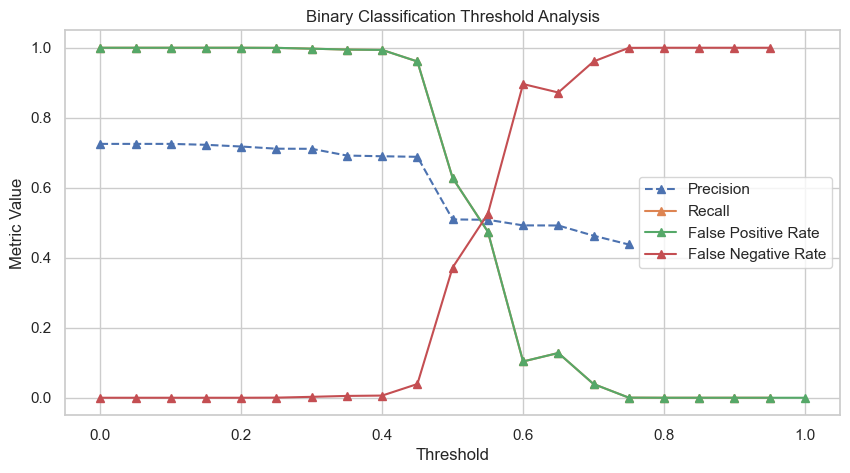

In [ ]:
# 绘制图表

plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")
sns.color_palette("Paired")
# 准确度
#plt.plot(thresholds, accuracy_list, label="Accuracy", marker='^')

# 精度
plt.plot(thresholds, precision_list, label="Precision", linestyle='--', marker='^')

# 召回率
plt.plot(thresholds, recall_list, label="Recall", marker='^')

# F1分数
#plt.plot(thresholds, f1_score_list, label="F1 Score",marker='^')

#假阳性
plt.plot(thresholds, fpr_list, label="False Positive Rate", marker='^')

#假阴性
plt.plot(thresholds, fnr_list, label="False Negative Rate", marker='^')


plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Binary Classification Threshold Analysis")
plt.legend()
# 添加网格
plt.grid(True)
plt.show()



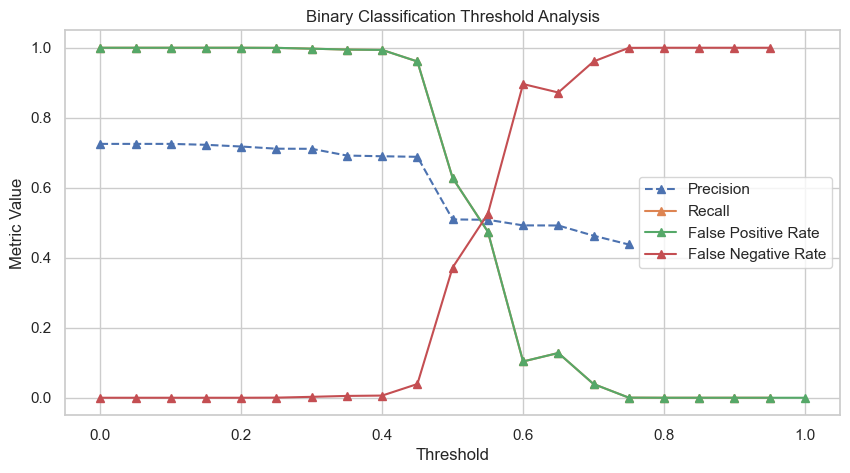

In [ ]:
# 绘制图表

plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")
sns.color_palette("Paired")
# 准确度
#plt.plot(thresholds, accuracy_list, label="Accuracy", marker='^')

# 精度
plt.plot(thresholds, precision_list, label="Precision", linestyle='--', marker='^')

# 召回率
plt.plot(thresholds, recall_list, label="Recall", marker='^')

# F1分数
#plt.plot(thresholds, f1_score_list, label="F1 Score",marker='^')

#假阳性
plt.plot(thresholds, fpr_list, label="False Positive Rate", marker='^')

#假阴性
plt.plot(thresholds, fnr_list, label="False Negative Rate", marker='^')


plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Binary Classification Threshold Analysis")
plt.legend()
# 添加网格
plt.grid(True)
plt.show()



In [ ]:

##################随机森林

##过拟合，减少树的数量

rf_model = RandomForestClassifier(n_estimators=10, random_state=42)  #100->10

# 使用交叉验证评估模型性能
# cv 参数指定了将数据集分成几份进行交叉验证，这里使用了 5 折交叉验证
# scoring 参数指定了评估指标，比如 'accuracy' 代表准确率
scores = cross_val_score(rf_model, X_train, y_train_binary, cv=5, scoring='accuracy')

rf_model.fit(X_train,y_train_binary)

# 输出交叉验证的结果
print("Cross-validated Accuracy:", scores)
print("Mean Accuracy:", scores.mean())

# 在测试集上评估模型性能
accuracy = rf_model.score(X_test, y_test_binary)
print(f'Test Accuracy: {accuracy}')


Cross-validated Accuracy: [1. 1. 1. 1. 1.]
Mean Accuracy: 1.0
Test Accuracy: 1.0


In [ ]:
# 假设 rf_model 是你的随机森林模型，X_train 和 y_train 是训练集的特征和标签
accuracy_train = rf_model.score(X_train, y_train_binary)
print(f'Training Accuracy: {accuracy_train}')
#Training Accuracy: 0.997081144191477 测试集准确率太高，过拟合了


Training Accuracy: 1.0


In [ ]:
y_test_binary.mean()

0.0

In [ ]:
from sklearn.metrics import roc_auc_score
# 使用 roc_auc_score 函数计算AUC
y_pred_binary = (rf_model.predict(X_test) > threshold).astype(int)
auc_score = roc_auc_score(y_test_binary, y_pred_binary)

print(f"AUC Score: {auc_score}")

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

# 每个变量

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


# Assuming 'data' contains the features and labels (overall, Review_Interval_Days, Readability, Polarity)
# X contains the features, y contains the labels
features = ['overall', 'Review_Interval_Days', 'Readability', 'Polarity','Subjectivity']
outcome = []
y = sample_data['usefulScore'].values
for i in features:
    X = sample_data[[i]].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build the neural network model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)  # Assuming 'usefulScore' is a regression task
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

    # Evaluate the model
    y_pred = model.predict(X_test)


    ######阈值？？？？？？？？？？？？？？useful>0.7 auc = 0.89
    # Create a new model
    model2 = Sequential()
    model2.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model2.add(Dense(1, activation='sigmoid'))

    # Compile the model with binary cross entropy loss
    model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Assuming X_train and y_train are your features and labels
    # Convert usefulScore to binary labels
    y_train_binary = (y_train > threshold).astype(int)

    # Train the model
    model2.fit(X_train, y_train_binary, epochs=10, batch_size=32, verbose=1)

    # Assuming X_test is your test data
    # Convert usefulScore to binary labels for test data
    y_test_binary = (y_test > threshold).astype(int)

    # Evaluate the model
    accuracy = model2.evaluate(X_test, y_test_binary)[1]
    outcome.append(f'Mean Squared Error for {i}: {mse} ,Accuracy: {accuracy}')
outcome




Epoch 1/50
250/250 [==============================] - 2s 3ms/step - loss: 0.1969 - val_loss: 0.1240
Epoch 2/50
250/250 [==============================] - 0s 2ms/step - loss: 0.1240 - val_loss: 0.1161
Epoch 3/50
250/250 [==============================] - 1s 2ms/step - loss: 0.1207 - val_loss: 0.1141
Epoch 4/50
250/250 [==============================] - 1s 3ms/step - loss: 0.1204 - val_loss: 0.1141
Epoch 5/50
250/250 [==============================] - 1s 3ms/step - loss: 0.1203 - val_loss: 0.1154
Epoch 6/50
250/250 [==============================] - 1s 3ms/step - loss: 0.1206 - val_loss: 0.1190
Epoch 7/50
250/250 [==============================] - 1s 3ms/step - loss: 0.1204 - val_loss: 0.1142
Epoch 8/50
250/250 [==============================] - 1s 3ms/step - loss: 0.1205 - val_loss: 0.1138
Epoch 9/50
250/250 [==============================] - 1s 3ms/step - loss: 0.1205 - val_loss: 0.1139
Epoch 10/50
250/250 [==============================] - 1s 3ms/step - loss: 0.1203 - val_loss: 0.1166

['Mean Squared Error for overall: 0.11421848563045928 ,Accuracy: 0.859499990940094',
 'Mean Squared Error for Review_Interval_Days: 0.11655410813972511 ,Accuracy: 0.859499990940094',
 'Mean Squared Error for Readability: 0.11560422779994574 ,Accuracy: 0.859499990940094',
 'Mean Squared Error for Polarity: 0.11705979347620382 ,Accuracy: 0.859499990940094',
 'Mean Squared Error for Subjectivity: 0.11629823427067197 ,Accuracy: 0.859499990940094']

In [ ]:


# Assuming 'data' contains the features and labels (overall, Review_Interval_Days, Readability, Polarity)
# X contains the features, y contains the labels
features = ['overall', 'Review_Interval_Days', 'Readability', 'Polarity','Subkectivity']
outcome = []
threshold = 0.4
for i in features:
    # ...
    # Your existing code for feature preprocessing

    # Create a new model
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with binary cross entropy loss
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Convert usefulScore to binary labels
    y_train_binary = (y_train > threshold).astype(int)

    # Train the model
    model.fit(X_train, y_train_binary, epochs=10, batch_size=32, verbose=1)

    # Assuming X_test is your test data
    # Convert usefulScore to binary labels for test data
    y_test_binary = (y_test > threshold).astype(int)

    # Evaluate the model
    accuracy = model.evaluate(X_test, y_test_binary)[1]

    outcome.append(f'Accuracy for {i}: {accuracy}')
outcome

Epoch 1/10
250/250 [==============================] - 3s 4ms/step - loss: 0.4396 - accuracy: 0.8506
Epoch 2/10
250/250 [==============================] - 1s 3ms/step - loss: 0.4037 - accuracy: 0.8547
Epoch 3/10
250/250 [==============================] - 1s 3ms/step - loss: 0.3997 - accuracy: 0.8547
Epoch 4/10
250/250 [==============================] - 1s 4ms/step - loss: 0.3982 - accuracy: 0.8547
Epoch 5/10
250/250 [==============================] - 1s 4ms/step - loss: 0.3967 - accuracy: 0.8547
Epoch 6/10
250/250 [==============================] - 1s 5ms/step - loss: 0.3959 - accuracy: 0.8547
Epoch 7/10
250/250 [==============================] - 1s 6ms/step - loss: 0.3951 - accuracy: 0.8553
Epoch 8/10
250/250 [==============================] - 1s 5ms/step - loss: 0.3947 - accuracy: 0.8549
Epoch 9/10
250/250 [==============================] - 1s 4ms/step - loss: 0.3949 - accuracy: 0.8539
Epoch 10/10
63/63 [==============================] - 1s 3ms/step - loss: 0.3836 - accuracy: 0.8655
E

['Accuracy for overall: 0.8654999732971191',
 'Accuracy for Review_Interval_Days: 0.8644999861717224',
 'Accuracy for Readability: 0.8665000200271606',
 'Accuracy for Polarity: 0.8644999861717224',
 'Accuracy for Subkectivity: 0.8640000224113464']